In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from Bio import SeqIO
import qbi_mutation_simulator_with_tsv as simulate_qbi_mutations

from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
data = pd.read_csv("uniprotkb_rhea_49528_2025_03_09 - More Data.csv")
data.head()

,Enzyme,Amino Acid Sequence,Substrate,SMILES Representation,KM (mM),Reference
0,EstB28,MSEIVLLKKIEKFKQEWGKADAKRDEGLSTSPKGIKRYDNLSYGHG...,pNP-acetate,CC(=O)Oc1ccc(cc1[N+](=O)[O-]),0.01154,https://www.researchgate.net/publication/26793...
1,EstB29,MSEIVLLKKIEKFKQEWGKADAKRDEGLSTSPKGIKRYDNLSYGHG...,pNP-butanoate,CCCC(=O)Oc1ccc(cc1[N+](=O)[O-]),0.01440,NaN
2,EstB30,MSEIVLLKKIEKFKQEWGKADAKRDEGLSTSPKGIKRYDNLSYGHG...,pNP-hexanoate,CCCCCC(=O)Oc1ccc(cc1[N+](=O)[O-]),0.03600,NaN
3,EstB31,MSEIVLLKKIEKFKQEWGKADAKRDEGLSTSPKGIKRYDNLSYGHG...,pNP-octanoate,CCCCCCCC(=O)Oc1ccc(cc1[N+](=O)[O-]),0.04700,NaN
4,EstB32,MSEIVLLKKIEKFKQEWGKADAKRDEGLSTSPKGIKRYDNLSYGHG...,pNP-decanoate,CCCCCCCCCC(=O)Oc1ccc(cc1[N+](=O)[O-]),0.07000,NaN


In [3]:
x_values = data[["Amino Acid Sequence", "SMILES Representation"]]
y_values = data["KM (mM)"]

x_values_list = []
for i in range(len(x_values)):
    x_values_list.append((x_values.iloc()[i][0], x_values.iloc()[i][1]))
    
y_values_list = list(y_values)

/var/folders/qj/gs5wv8ns0q540g2rb18y0ky00000gp/T/ipykernel_52877/1623059080.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values_list.append((x_values.iloc()[i][0], x_values.iloc()[i][1]))


In [4]:
class AminoSmilesRegression:
    """
    A class for training and using a linear regression model with
    amino acid sequences and SMILES strings as input.
    """
    
    def __init__(self, smiles_bits=1024):
        self.smiles_bits = smiles_bits
        self.aa_encoder = None
        self.max_aa_length = None
        self.model = LinearRegression()
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY_'  # Include padding character
        
    def _encode_amino_acid_sequence(self, sequences):
        """
        One-hot encode a list of amino acid sequences with consistent feature space
        """
        # Determine max length if not already set (during training)
        if self.max_aa_length is None:
            self.max_aa_length = max(len(seq) for seq in sequences)
            
        # Pad sequences to ensure consistent length
        padded_sequences = [seq.ljust(self.max_aa_length, '_') for seq in sequences]
        
        # Replace any amino acids not in our standard set with '_'
        cleaned_sequences = []
        for seq in padded_sequences:
            cleaned_seq = ''.join([aa if aa in self.amino_acids else '_' for aa in seq])
            cleaned_sequences.append(cleaned_seq)
            
        # Create one-hot encoding
        result = []
        for seq in cleaned_sequences:
            seq_encoding = []
            for aa in seq:
                # One-hot vector for each position
                one_hot = [1 if aa == amino_acid else 0 for amino_acid in self.amino_acids]
                seq_encoding.extend(one_hot)
            result.append(seq_encoding)
            
        return np.array(result)
        
    def _encode_smiles(self, smiles_list):
        """
        Encode SMILES strings with consistent feature space
        """
        fingerprints = []
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    fingerprints.append(np.zeros(self.smiles_bits))
                else:
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=self.smiles_bits)
                    fingerprints.append(np.array(fp))
            except:
                fingerprints.append(np.zeros(self.smiles_bits))
                
        return np.array(fingerprints)
    
    def fit(self, aa_smiles_tuples, y_values, test_size=0.2, random_state=42):
        """
        Train the regression model on amino acid and SMILES data
        """
        # Extract sequences and SMILES
        aa_sequences = [tup[0] for tup in aa_smiles_tuples]
        smiles_strings = [tup[1] for tup in aa_smiles_tuples]
        
        # Encode features
        X_aa = self._encode_amino_acid_sequence(aa_sequences)
        X_smiles = self._encode_smiles(smiles_strings)
        
        # Store the feature dimensionality for reference
        self.aa_feature_dim = X_aa.shape[1]
        self.smiles_feature_dim = X_smiles.shape[1]
        
        # Combine encodings
        X_combined = np.hstack((X_aa, X_smiles))
        
        # Split and train
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y_values, test_size=test_size, random_state=random_state
        )
        
        self.model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Training complete")
        print(f"Feature dimensions: {X_combined.shape[1]} total features")
        print(f"  - Amino acid features: {self.aa_feature_dim}")
        print(f"  - SMILES features: {self.smiles_feature_dim}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R-squared: {r2:.4f}")
        
        return X_test, y_test, y_pred
    
    def predict(self, aa_smiles_tuples):
        """
        Make predictions on new data
        """
        if self.max_aa_length is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
            
        # Extract sequences and SMILES
        aa_sequences = [tup[0] for tup in aa_smiles_tuples]
        smiles_strings = [tup[1] for tup in aa_smiles_tuples]
        
        # Encode with the same process as training
        X_aa = self._encode_amino_acid_sequence(aa_sequences)
        X_smiles = self._encode_smiles(smiles_strings)
        
        # Check dimensions
        if X_aa.shape[1] != self.aa_feature_dim:
            raise ValueError(f"Amino acid encoding produced {X_aa.shape[1]} features, expected {self.aa_feature_dim}")
        if X_smiles.shape[1] != self.smiles_feature_dim:
            raise ValueError(f"SMILES encoding produced {X_smiles.shape[1]} features, expected {self.smiles_feature_dim}")
        
        # Combine and predict
        X_combined = np.hstack((X_aa, X_smiles))
        return self.model.predict(X_combined)

In [5]:
# Specify the path to your FASTA file
fasta_file = 'reference.fasta'

# Open the file and iterate over its contents
for record in SeqIO.parse(fasta_file, 'fasta'):
    reference_fatsa_seq = str(record.seq)

    # Print the record ID and the sequence
    # print(f"ID: {record.id}")
    # print(f"Description: {record.description}")
    # print(f"Sequence: {record.seq}\n")

In [17]:
#Generate Variants
sequences, mutations = simulate_qbi_mutations.process_fasta(
    input_file="reference.fasta",
    mutation_prob=0.7,
    num_variants=5000
    )

variant_sequences = [str(sequence.seq) for sequence in sequences]

/Users/cagrahar/.local/share/mamba/envs/epic_cc3d/lib/python3.11/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [18]:
 # New data
aa_smiles_tuples = x_values_list

# Sample numerical target values (e.g., binding affinity in nM)
y_values = y_values_list 

# Create and train model
regressor = AminoSmilesRegression(smiles_bits=1024)
X_test, y_test, y_pred = regressor.fit(aa_smiles_tuples, y_values)

# Make predictions on new data
new_data = [(variant_sequence, "C1=CC(=CC=C1C(=O)O)C(=O)OCCOC(=O)C2=CC=C(C=C2)C(=O)O") for variant_sequence in variant_sequences]

km_values = []

try:
    predictions = regressor.predict(new_data)
    print("\nPredictions for new data:")
    for data, pred in zip(new_data, predictions):
        # print(f"AA: {data[0][:10]}... SMILES: {data[1][:10]}... - Predicted value: {pred:.2f}")
        km_values.append(np.round(pred,2))
except ValueError as e:
    print(f"Error during prediction: {e}")
    
# # Print feature dimensions for debugging
# print(f"\nModel expects:")
# print(f"  - {regressor.aa_feature_dim} amino acid features")
# print(f"  - {regressor.smiles_feature_dim} SMILES features")
# print(f"  - {regressor.aa_feature_dim + regressor.smiles_feature_dim} total features")

[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerator
[16:13:06] DEPRECATION WARNING: please use MorganGenerat

Training complete
Feature dimensions: 7345 total features
  - Amino acid features: 6321
  - SMILES features: 1024
Mean Squared Error: 33.4668
R-squared: -3.6449


[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerator
[16:13:08] DEPRECATION WARNING: please use MorganGenerat


Predictions for new data:


Text(0, 0.5, 'Counts')

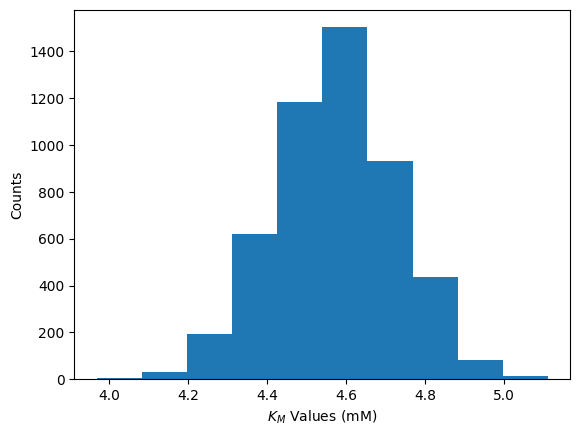

In [21]:
plt.hist(km_values)
plt.xlabel("$K_M$ Values (mM)")
plt.ylabel("Counts")